(7.0, 15.0)

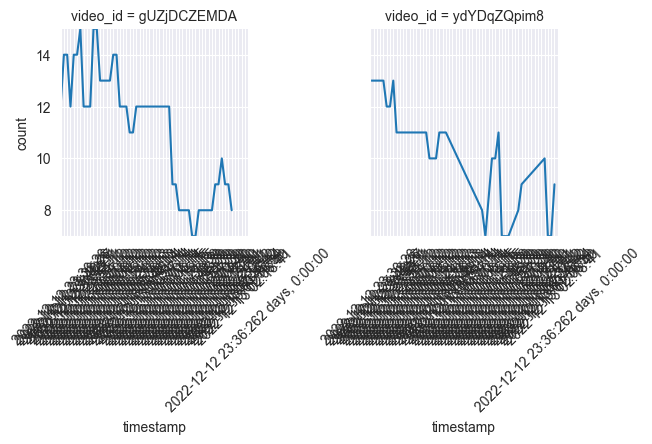

In [82]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

# Create empty dict
file_dict = {}

# Get list of files in directory
files = os.listdir('data/images/cropped')

# Loop through the files
for file in files:
    # Split the filenames
    parts = file.split('_')
    if parts[0] == 'image':
        video_id = parts[1]
        timestamp = parts[2] + "_" + parts[3]
        # Convert the timestamp string to a datetime object
        timestamp = pd.to_datetime(timestamp, format='%Y-%m-%d_%H-%M-%S')
        # Create a key for the dictionary using the video_id and timestamp
        key = f"{video_id}_{timestamp}"
        # If the key doesn't exist in the dictionary, create a new list for it
        if key not in file_dict:
            file_dict[key] = []
        # Append the file path to the list of file paths for this key
        file_dict[key].append(os.path.join('data/images/cropped', file))


# Create pandas dataframe from the dictionary
df = pd.DataFrame(columns=['video_id', 'timestamp', 'count'])
for key, value in file_dict.items():
    # Get the count of file paths for the current key
    count = len(value)
    
    # Split the key string to extract the video_id and timestamp
    key_parts = key.split('_')
    video_id = key_parts[0]
    timestamp = key_parts[1]
    
    # Create a new DataFrame for the current key
    new_df = pd.DataFrame({'video_id': [video_id], 'timestamp': [timestamp], 'count': [count]})
    
    # Append the new DataFrame to the existing DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

df['count'] = pd.to_numeric(df['count'], errors='coerce')

df = df.groupby(['video_id', 'timestamp'])['count'].sum().reset_index()

# Sort the dataframe by the timestamp column
df = df.sort_values('timestamp')







# Create a FacetGrid with one row and one column for each unique value in the 'video_id' column
grid = sns.FacetGrid(df, col='video_id', col_wrap=4, height=3)


# Iterate over the grid and create a lineplot for each 'video_id'
grid.map(sns.lineplot, 'timestamp', 'count')

# Set the x-axis limits to cover a few days
plt.xlim(xmin, xmin + str(timedelta(days=2)))

# Get the minimum and maximum values of the 'count' column
ymin, ymax = df['count'].min(), df['count'].max()

# Set the x-axis tick labels
grid.set_xticklabels(rotation=45)

# Set the y-axis limits to cover the range of values in the 'count' column
plt.ylim(ymin, ymax)



In [56]:
df

,video_id,timestamp,count
0,gUZjDCZEMDA,2022-12-12 23:36:26,12
53,ydYDqZQpim8,2022-12-12 23:36:26,13
1,gUZjDCZEMDA,2022-12-12 23:38:26,14
54,ydYDqZQpim8,2022-12-12 23:38:26,13
2,gUZjDCZEMDA,2022-12-12 23:40:27,14
...,...,...,...
48,gUZjDCZEMDA,2022-12-13 02:24:41,9
49,gUZjDCZEMDA,2022-12-13 02:27:41,10
50,gUZjDCZEMDA,2022-12-13 02:30:42,9
51,gUZjDCZEMDA,2022-12-13 02:33:42,9
